<a href="https://colab.research.google.com/github/sofia-sunny/Generative/blob/main/Generative_SMILES_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **De Novo Drug Design Using SMILES-RNN: Generating Novel EGFR Inhibitors**

**Erlotinib** is a targeted cancer therapy that acts as an inhibitor of the Epidermal Growth Factor Receptor (EGFR) tyrosine kinase and therefore serves as a valuable starting point for drug discovery efforts. In this project, we aim to use the  [SMILES-RNN](https://github.com/MorganCThomas/SMILES-RNN) generative model by Morgan Thomas to perform de novo drug design, starting from the SMILES of erlotinib. The goal is to generate novel molecules that retain or improve upon erlotinib’s activity while potentially offering better pharmacokinetic properties or overcoming resistance mechanisms.

Let’s begin by installing and importing the necessary packages

**Note:** To accelerate the reinforcement learning run, enable GPU in Google Colab. Navigate to **Runtime > Change runtime type**, select GPU as the hardware accelerator, and click Save

If you prefer not to run the reinforcement learning—which can take several minutes depending on GPU availability—you can instead download the results from a previous run. See below (**Using Pre-Generated Results**)

In [ ]:
import sys
import subprocess

if "google.colab" in sys.modules:
    from IPython.utils import io

    print("Running in Google Colab. Installing required packages...")

    with io.capture_output():
        subprocess.run([
            "pip", "install",
            "smiles-rnn",
            "molscore",
            "useful_rdkit_utils",
            "mols2grid",
            "seaborn"
        ])
    print("Installation complete!")

Running in Google Colab. Installing required packages...
Installation complete!


In [ ]:
import urllib
from glob import glob
import os
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import Image, display
import useful_rdkit_utils as uru
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import BulkTanimotoSimilarity
import mols2grid

**tqdm.pandas()** is a handy utility that adds a progress bar to pandas operations like .apply() or .groupby() so you can visually track their progress — **especially useful when working with large datasets.**

In [ ]:
tqdm.pandas()

### **Reinforcement Learning Script**
The **reinforcement_learning.py** script is retrieved from the SMILES-RNN GitHub repository to serve as the central module for executing reinforcement learning in de novo molecular design. It coordinates the interaction between a pretrained SMILES-based generative model and a user-defined scoring function, enabling the model to iteratively refine and generate molecules with optimized properties

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/MorganCThomas/SMILES-RNN/main/scripts/reinforcement_learning.py", "reinforcement_learning.py")

('reinforcement_learning.py', <http.client.HTTPMessage at 0x790de6481190>)

### **Pretrained Model Checkpoint**
The file **ChEMBL28pur.ckpt** contains a pretrained model checkpoint based on the ChEMBL28 dataset. It represents a SMILES-based recurrent neural network (RNN) that has been trained on a large collection of bioactive molecules. In the reinforcement learning framework, this file serves as the **prior model**—the starting point from which new molecules are generated and optimized.

Using a pretrained prior accelerates convergence, ensures syntactic validity of generated SMILES, and provides a chemically meaningful foundation for downstream optimization.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/MorganCThomas/SMILES-RNN/main/priors/ChEMBL28pur.ckpt","ChEMBL28pur.ckpt")

('ChEMBL28pur.ckpt', <http.client.HTTPMessage at 0x790de6323910>)

### **Reference molecule and Json Scoring file**
We will use the generative model to create novel molecular structures that are similar to our reference compound, **Erlotinib** (the clinically approved EGFR inhibitor used in cancer therapy)

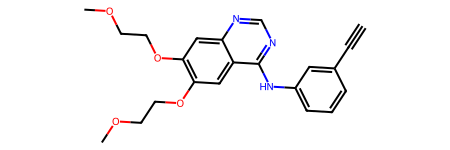

In [ ]:
erlotinib_smiles = 'COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC'
erlotinib_mol = Chem.MolFromSmiles(erlotinib_smiles)
erlotinib_mol

As our reference molecule is Erlotinib, we utilize a JSON scoring file **(erlotinib_similarity.json)** to guide the molecular generation process toward producing novel compounds structurally related to Erlotinib.

This file encodes a similarity-based reward function, which evaluates each generated molecule based on its structural resemblance to Erlotinib. During reinforcement learning, this reward function plays a critical role in optimizing the generative model, encouraging it to prioritize molecules that retain key pharmacophoric features of Erlotinib while exploring new chemical space.


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sofia-sunny/Generative/main/data/erlotinib_similarity.json", "erlotinib_similarity.json")


('erlotinib_similarity.json', <http.client.HTTPMessage at 0x790de6349750>)

### **Using Pre-Generated Results**
### **If you prefer not to run the reinforcement learning**—which can take several minutes depending on GPU availability—you can instead download the results from a previous run. This allows you to skip the training phase and move directly to analyzing the output molecules or continuing with downstream tasks

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sofia-sunny/Generative/main/data/2025_07_19_SMILES-RNN_erlotinib_similarity.tar.gz","2025_07_19_SMILES-RNN_erlotinib_similarity.tar.gz")

('2025_07_19_SMILES-RNN_erlotinib_similarity.tar.gz',
 <http.client.HTTPMessage at 0x790de634a110>)

Unpack the results from the previous run.

In [ ]:
!tar -zxf 2025_07_19_SMILES-RNN_erlotinib_similarity.tar.gz

## **Running the RNN with Reinforcement Learning**
### If you attempt to run the reinforcement learning (RL) process by executing reinforcement_learning.py with the required input files, you may encounter the following error:

**_pickle.UnpicklingError: Weights only load failed**

In [ ]:
#!python reinforcement_learning.py -p ChEMBL28pur.ckpt -m fragment_005_similarity.json --model RNN -d gpu RV2


This issue arises because, starting with PyTorch 2.6+, the **torch.load() function** sets **weights_only=True** by default. This setting is intended to load only the model weights, but in our case, it is too strict—our saved checkpoints contain more than just weights (e.g., optimizer state, training metadata), and the loader fails to deserialize the full object.

To resolve this issue, we need to manually edit the SMILES-RNN source file **rnn.py**, which handles loading the saved model checkpoints.

To locate rnn.py:

In [ ]:
import smilesrnn
import os

rnn_path = os.path.join(os.path.dirname(smilesrnn.__file__), "rnn.py")
print("rnn.py is located at:", rnn_path)

rnn.py is located at: /usr/local/lib/python3.11/dist-packages/smilesrnn/rnn.py


After locating the rnn.py file, make a working copy of the so you can safely edit it. This creates a new file named rnn_editable.py in your working directory.

In [ ]:
!cp /usr/local/lib/python3.11/dist-packages/smilesrnn/rnn.py rnn_editable.py

### Open **rnn_editable.py** using the file browser in Google Colab (left-side panel). Then, locate  the **torch.load() Block** you will see:

```
if torch.cuda.is_available():
    save_dict = torch.load(file_path, map_location=device)

else:
    save_dict = torch.load(file_path, map_location=lambda storage, loc: storage)
 ```

Delete the entire **if-else** block above and replace it with this updated version to set the  **weights_only=False**. This tells PyTorch to load the entire checkpoint, not just model weights—fixing the error introduced in PyTorch 2.6+

```
import torch.serialization
from smilesrnn.vocabulary import Vocabulary
torch.serialization.add_safe_globals([Vocabulary])
if torch.cuda.is_available():
    save_dict = torch.load(file_path, map_location=device, weights_only=False)
else:
    save_dict = torch.load(file_path, map_location=lambda storage, loc: storage, weights_only=False)
```

Once you’ve made the changes save the file.

Now overwrite the original rnn.py file using:

In [ ]:
!cp rnn_editable.py /usr/local/lib/python3.11/dist-packages/smilesrnn/rnn.py

We can now proceed to run reinforcement learning using the SMILES-RNN model (remove the "#" character from the beginning of the line below.).

The command launches the reinforcement learning session that fine-tunes a pretrained RNN model (**ChEMBL28pur.ckpt**) to generate molecules optimized according to a custom scoring function defined in **erlotinib_similarity.json**.

⏱️ **Note:** This process typically takes less than 5 minutes on Google Colab with GPU enabled. However, if you prefer not to wait, you can use the results from the previous run (see above) and use them directly as explained in the next step

In [ ]:
!python reinforcement_learning.py -p ChEMBL28pur.ckpt -m erlotinib_similarity.json --model RNN -d gpu RV2


OpenEye functions: currently unavailable due to the following: No module named 'openeye'
PoseCheck metrics: currently unavailable due to the following: No module named 'prolif'
2025-07-23 17:11:37.401887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753290697.424463    3840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753290697.431561    3840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Device set to cuda
100% 250/250 [03:22<00:00,  1.23it/s]


## **Cleaning the Output Data:**
Now that we’ve run the LR in SMILES-RNN (or if you’re using the pre-generated output), the next step is to  retrieve the **scores.csv file** from the SMILES-RNN_erlotinib_similarity directory

In [ ]:
files = glob("*SMILES-RNN_erlotinib_similarity")
files.sort(key=os.path.getmtime)
dir_path = files[0]
dir_path

'2025_07_19_SMILES-RNN_erlotinib_similarity'

In [ ]:
df = pd.read_csv(f"{dir_path}/scores.csv")
df

,Unnamed: 0,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,filter,score_time,prior,agent,batch_size,rl_strategy,sigma,loss,prior_nll,agent_nll
0,0,RNN,erlotinib_similarity,0,0,3.30473,CC(=O)NCCc1cn(Cc2ccccc2C#N)c2ccccc12,True,1,True,...,1.0,0.130312,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2089.7970,26.240952,26.240963
1,1,RNN,erlotinib_similarity,0,1,3.30473,O=C(Nc1ccc(F)c(CN2CCOCC2)c1)c1cc(N2C(=O)CC2c2c...,True,1,True,...,1.0,0.130312,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2282.7130,43.965730,43.965694
2,2,RNN,erlotinib_similarity,0,2,3.30473,Nc1nc(C#Cc2ccccc2)nc2c1ncn2C1OC(CO)C(O)C1O,True,1,True,...,1.0,0.130312,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2616.0710,16.376574,16.376575
3,3,RNN,erlotinib_similarity,0,3,3.30473,O=C(NCc1ccc(F)cc1Cl)c1ccc(C(F)(F)F)nc1N1CCOCC1,True,1,True,...,1.0,0.130312,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,2242.9675,26.613450,26.613428
4,4,RNN,erlotinib_similarity,0,4,3.30473,c1ccc(Oc2ccc(C3CCNCC3)cc2)cc1,True,1,True,...,1.0,0.130312,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,1869.9791,17.416227,17.416239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,31995,RNN,erlotinib_similarity,249,123,193.98578,COCCOc1ccc2ncnc(Nc3ccccc3)c2c1,True,1,False,...,1.0,0.045004,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,6181.1685,21.347450,0.837426
31996,31996,RNN,erlotinib_similarity,249,124,193.98578,COCCOc1ccc2c(Nc3ccccc3)ncnc2c1,True,1,False,...,1.0,0.045004,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,6057.6113,21.902237,0.602460
31997,31997,RNN,erlotinib_similarity,249,125,193.98578,COCCOc1ccc2c(Nc3ccccc3)ncnc2c1,True,1,False,...,1.0,0.045004,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,6057.6113,21.902237,0.602460
31998,31998,RNN,erlotinib_similarity,249,126,193.98578,COCCOc1ccc2ncnc(Nc3ccccc3)c2c1,True,1,False,...,1.0,0.045004,ChEMBL28pur.ckpt,ChEMBL28pur.ckpt,128,RV,120,6181.1685,21.347450,0.837426


In [ ]:
df_distinct = df.drop_duplicates(subset=["smiles"]).copy()
len(df_distinct)

8825

So, out of the 32,000 generated molecules, only 8,825 are unique. Next, we want to check how many of these represent valid molecules. To do this, we first convert each SMILES string into an RDKit Mol object and then verify which of these objects are valid.

In [ ]:
df_distinct["mol"] = df_distinct["smiles"].apply(Chem.MolFromSmiles)

In [ ]:
sum(df_distinct["mol"].isna())

525

We remove the 525 molecules that are not valid

In [ ]:
df_clean = df_distinct.dropna().copy()
len(df_clean)

8300

**Filtering Molecules with Uncommon Ring Systems**

For more details, see  [Pat Walters' blog post on ring system analysis](https://practicalcheminformatics.blogspot.com/2022/12/identifying-ring-systems-in-molecules.html).

Although molecules that violate basic valence rules have already been removed, some structures may still be chemically unstable. One effective approach to identify such cases is to compare the ring systems found in the generated molecules against those present in the ChEMBL database. **Molecules containing ring systems not observed in ChEMBL are likely to be unstable or synthetically challenging.**

The code below enhances the DataFrame by adding two informative columns:

**min_ring** – the least common ring system present in each molecule

**min_freq** – the number of times that specific ring system appears in the ChEMBL dataset

An instance of the **RingSystemLookup** class from the **useful_rdkit_utils (uru)** allows for efficient comparison of each molecule’s ring systems against those found in ChEMBL. By identifying rare or novel ring systems, it helps detect molecules that may be chemically unstable or challenging to synthesize.
A **RingSystemLookup object** is used to identify and analyze the ring systems present in each molecule.

In [ ]:
check_ring_system = uru.RingSystemLookup()
df_clean['ring_systems'] = df_clean.mol.progress_apply(check_ring_system.process_mol)
df_clean.ring_systems.head()

  0%|          | 0/8300 [00:00<?, ?it/s]

,ring_systems
0,"[(c1ccc2[nH]ccc2c1, 108866), (c1ccccc1, 2568039)]"
1,"[(c1ccccc1, 2568039), (C1COCCN1, 83461), (c1cn..."
2,"[(c1ncc2nc[nH]c2n1, 26701), (c1ccccc1, 2568039..."
3,"[(c1ccccc1, 2568039), (c1ccncc1, 275595), (C1C..."
4,"[(c1ccccc1, 2568039), (c1ccccc1, 2568039), (C1..."


For example, in **row 0**, the molecule contains two ring systems:

**c1ccc2[nH]ccc2c1**, found 108,866 times in ChEMBL

**c1ccccc1 (benzene)**, found 2,568,039 times in ChEMBL

For each list of ring systems in the ring_systems column, the **get_min_ring_frequency function** is used to determine which ring system is least frequently observed in the ChEMBL database. The output is assigned to two new columns: **min_ring,** which contains the rarest ring system in each molecule, and **min_freq,** which records how often that ring appears in ChEMBL. This identification is essential for flagging molecules that may contain rare, synthetically challenging, or potentially unstable ring systems.

In [ ]:
df_clean[['min_ring','min_freq']] = [uru.get_min_ring_frequency(x) for x in df_clean.ring_systems]
df_clean[['ring_systems','min_ring','min_freq']].head()

,ring_systems,min_ring,min_freq
0,"[(c1ccc2[nH]ccc2c1, 108866), (c1ccccc1, 2568039)]",c1ccc2[nH]ccc2c1,108866
1,"[(O=C1CCN1, 3390), (C1COCCN1, 83461), (c1cncnc...",O=C1CCN1,3390
2,"[(c1ncc2nc[nH]c2n1, 26701), (C1CCOC1, 54820), ...",c1ncc2nc[nH]c2n1,26701
3,"[(C1COCCN1, 83461), (c1ccncc1, 275595), (c1ccc...",C1COCCN1,83461
4,"[(C1CCNCC1, 212367), (c1ccccc1, 2568039), (c1c...",C1CCNCC1,212367


If the minimum frequency of a ring system is below 100, it suggests that the molecule contains a ring system that is extremely rare or possibly absent from well-characterized chemical space.

In [ ]:
len(df_clean.query("min_freq < 100"))

597

So, 597 molecules contain at least one ring system that occurs fewer than 100 times in the ChEMBL database. These ring systems are considered questionable, as their rarity suggests they may be chemically unstable, synthetically challenging, or not commonly observed in known bioactive compounds. Filtering out such molecules can help improve the overall quality and realism of the generated datas

In [ ]:
df_clean_good_ring = df_clean.query("min_freq > 100 or min_freq < 0").copy()
# "or min_freq" < 0" is to retain the acyclic molecules.
len(df_clean_good_ring)

7701

### **Functional Group Filtering with REOS for Enhanced Molecule Quality**
Following the removal of molecules with questionable ring systems, further refinement is necessary to eliminate structures containing undesirable or reactive functional groups. This is accomplished using the **REOS (Rapid Elimination of Swill**) filters available in the useful_rdkit_utils package. These well-established filters are designed to flag substructures known to compromise chemical stability, selectivity, or developability.

For more information on functional group filtering, refer to the Pat Walters' [Filtering Chemical Libraries](https://practicalcheminformatics.blogspot.com/2018/08/filtering-chemical-libraries.html).

Here, an instance of the **REOS class** from the useful_rdkit_utils package is used to evaluate each molecule in df_clean_good_ring for undesirable functional groups, returning a tuple for each molecule that includes:

**rule_set:** the category of the violated REOS rule

**rule:** the specific functional group or pattern responsible

Molecules with no violations receive ok, indicating they meet REOS criteria for chemical acceptability.

In [ ]:
reos = uru.REOS()
df_clean_good_ring[["rule_set","rule"]] = df_clean_good_ring.mol.progress_apply(reos.process_mol).to_list()
df_clean_good_ring[["rule_set","rule"]].head()

  0%|          | 0/7701 [00:00<?, ?it/s]

,rule_set,rule
0,ok,ok
1,Glaxo,I16 Betalactams
2,ok,ok
3,ok,ok
4,ok,ok


The distribution of **REOS rule violations** among the molecules after applying functional group filtering can be founseen by:

In [ ]:
df_clean_good_ring.rule.value_counts()

,count
rule,
ok,7612
I5 Thiols,15
"I6 Epoxides, Thioepoxides, Aziridines",12
"R18 Quaternary C, Cl, I, P or S",12
I16 Betalactams,8
I13 Cyanamides,8
R7 Peroxides,8
R5 Sulphonates,6
I14 Four membered lactones,6


Each row corresponds to a specific **REOS rule** that flagged at least one molecule, and the **count** indicates how many molecules triggered that rule.

For example:

**ok** – 7612 molecules passed all REOS filters with no flagged functional groups.

**I5 Thiols**– 15 molecules contain thiol groups, which are reactive and often avoided in drug development.

**I6 Epoxides, Thioepoxides, Aziridines** – 12 molecules include strained three-membered rings, which are highly reactive.

**R18 Quaternary C, Cl, I, P or S** – 12 molecules contain certain quaternary atoms that may affect stability or synthesis.

**I16 Betalactams** – 8 molecules contain β-lactam rings, which are chemically strained and can be reactive outside of specific antibiotic contexts.

### Now we only keep the molecules that are ok

In [ ]:
df_all_ok = df_clean_good_ring.query("rule_set == 'ok'").copy()
len(df_all_ok)

7612

So, of the 32,000 generated molecules, 7612 are unique and meet basic chemical criteria, including acceptable ring systems and functional groups, indicating suitability for further drug discovery analysis.

## **Similarity Filtering and Clustering of Erlotinib-Like Molecules**
To prioritize meaningful candidates from our generated molecules, we first identify those with a **Tanimoto similarity** greater than 0.35 to the reference compound, Erlotinib. This similarity threshold ensures we retain molecules with potential biological relevance while allowing structural diversity. We then apply **Taylor–Butina clustering** to group the filtered molecules based on their structural fingerprints.

the process begins by generating molecular fingerprints for all compounds using the Morgan fingerprint algorithm, which encodes structural features into a binary vector representation

In [ ]:
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
df_all_ok["fp"] = df_all_ok.mol.progress_apply(lambda x: fp_gen.GetFingerprint(x))

  0%|          | 0/7612 [00:00<?, ?it/s]

By generating a fingerprint for Erlotinib and comparing it to the fingerprints of all other molecules using the Tanimoto similarity metric, we quantify the degree of overlap in their structural features.

In [ ]:
erlotinib_fp = fp_gen.GetFingerprint(erlotinib_mol)
df_all_ok["similarity"] = BulkTanimotoSimilarity(erlotinib_fp,df_all_ok.fp.values)
df_all_ok.similarity.describe()

,similarity
count,7612.000000
mean,0.215052
std,0.103806
min,0.000000
25%,0.137500
50%,0.194444
75%,0.264706
max,0.730769


We focus on molecules with meaningful structural similarity to the reference compound by keeping only those with a Tanimoto similarity greater than 0.35.

In [ ]:
good_similar_df = df_all_ok.query("similarity > 0.35").copy()
len(good_similar_df)

875

The **Taylor-Butina clustering** algorithm groups molecules based on fingerprint similarity using a defined Tanimoto cutoff. It ensures that each molecule is assigned to only one cluster, resulting in non-overlapping groups of structurally similar compounds. In this case, a cutoff of 0.35 is used to identify meaningful clusters for diversity analysis and virtual screening

In [ ]:
good_similar_df['cluster'] = uru.taylor_butina_clustering(good_similar_df.fp.values,cutoff=0.35)

To see how molecules are distributed across clusters:

In [ ]:
good_similar_df.cluster.value_counts()

,count
cluster,
0,255
1,87
4,49
2,40
3,34
...,...
146,1
72,1
114,1


Along with displaying Erlotinib, we can visualize the contents of a specific cluster using **mols2grid**. This allows for clear comparison between the reference compound and the structurally similar molecules within the selected cluster.

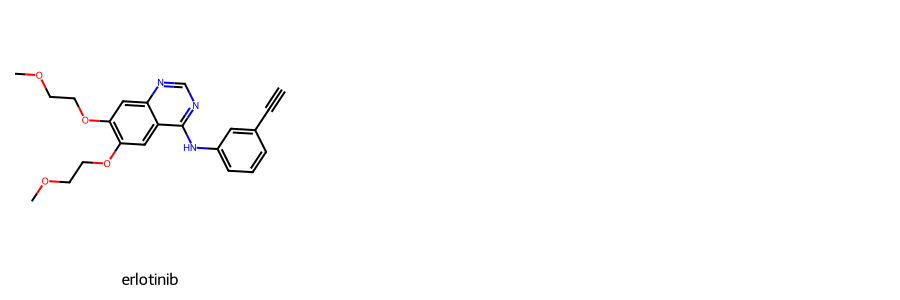

In [ ]:
erlotinib_img =Chem.Draw.MolsToGridImage([erlotinib_mol], legends=['erlotinib'], subImgSize=(300, 300))
display(erlotinib_img)

In [ ]:
cluster_num = 10
mols2grid.display(
    good_similar_df.query("cluster == @cluster_num"),smiles_col="smiles",
    subset=["img"],
    size=(300, 200)
)

MolGridWidget()

So, we have clusters of generated molecules similar to Erlotinib that can be used to explore structural diversity around the core scaffold, identify promising analogs, and guide further optimization in the drug design proces